**Table of contents**<a id='toc0_'></a>    
- 1. [Count earthquakes around LFEs in Parkfield    ](#toc1_)    
- 2. [Load and prepare data   ](#toc2_)    
  - 2.1. [Load earthquake catalog   ](#toc2_1_)    
  - 2.2. [Load LFE catalog   ](#toc2_2_)    
  - 2.3. [Project along strike  ](#toc2_3_)    
- 3. [Count earthquakes around LFE families ](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Count earthquakes around LFEs in Parkfield     [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

In [2]:
# Geographic distance
def distance(lon1, lat1, z1, lon2, lat2, z2):
    # Convert degrees to radians
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)

    # Compute differences in longitude and latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance_km = 6371 * c

    distance_km = np.sqrt(distance_km**2 + (z2 - z1)**2)

    return distance_km

# 2. <a id='toc2_'></a>Load and prepare data    [&#128285;](#toc0_)

In [3]:
# Constants
day0 = np.datetime64('2006-06-01')

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog    [&#128285;](#toc0_)

In [4]:
# Load earthquakes
# --> First, base catalog
path = workdir + "projects/data/Catalogs/nocal_felix_84_24/NCAeqDD.v202112.1"

with open(path, 'r') as f:
    lines = f.readlines()

lines = lines[97:]  # remove header

year = []
month = []
day = []
hour = []
minute = []
second = []
lon = []
lat = []
depth = []
mag = []
for line in lines:
    line = line.split()
    year.append(int(line[0]))
    month.append(int(line[1]))
    day.append(int(line[2]))
    hour.append(int(line[3]))
    minute.append(int(line[4]))
    second.append(float(line[5]))
    lat.append(float(line[6]))
    lon.append(float(line[7]))
    depth.append(float(line[8]))
    mag.append(float(line[-2]))

eq_base = pd.DataFrame({'year': year, 'month': month, 'day': day, 'hour': hour, 'minute': minute, 'second': second, 'lon': lon, 'lat': lat, 'depth': depth, 'mag': mag})
eq_base['date'] = pd.to_datetime(eq_base[['year', 'month', 'day', 'hour', 'minute', 'second']])

eq_base = eq_base[['date', 'lon', 'lat', 'depth', 'mag']]

# --> Second, real-time catalog
path = workdir + "projects/data/Catalogs/nocal_felix_84_24/NCAeqDD.v202112.1.RT_0122_0824"

cols = ['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon', 'depth', 'ex', 'ey', 'ez', 'mag', 'id', 'ver', 'base', 'meth']
eq_rt = pd.read_csv(path, delim_whitespace=True, names=cols, skiprows=78)   

eq_rt['date'] = pd.to_datetime(eq_rt[['year', 'month', 'day', 'hour', 'minute', 'second']])
eq_rt = eq_rt[['date', 'lon', 'lat', 'depth', 'mag']]

# --> Merge catalogs
eq = pd.concat([eq_base, eq_rt], ignore_index=True)
eq = eq.sort_values('date')

# --> Trim catalogs
after_2006 = eq['date'] >= np.datetime64('2006-06-01')

lon_min = -122.5
lon_max = -118.5
lat_min = 34.5
lat_max = 37.5
in_box = (eq['lon'] >= lon_min) & (eq['lon'] <= lon_max) & (eq['lat'] >= lat_min) & (eq['lat'] <= lat_max)

eq = eq[after_2006 & in_box]

# --> Days since 2006-06-01
eq['days'] = (eq['date'] - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_5459/2068584615.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  eq_rt = pd.read_csv(path, delim_whitespace=True, names=cols, skiprows=78)


## 2.2. <a id='toc2_2_'></a>Load LFE catalog    [&#128285;](#toc0_)

In [5]:
# Shelly catalog
# --> Load catalog
CAT_PATH = workdir + 'projects/data/Catalogs/saf_lfes/saf_lfes_shelly17_extended.txt'
COL_NAMES = [ "year", "month", "day", "s_of_day", "hour", "minute", "second", "ccsum", "meancc", 
             "med_cc", "seqday", "ID", "lat", "lon", "depth", "n_chan" ]
lfe = pd.read_csv(
    CAT_PATH,
    names=COL_NAMES,
    comment='%',
    delim_whitespace=True,
    index_col=False
    )
lfe["date"] = pd.to_datetime(lfe[["year", "month", "day", "hour", "minute", "second"]])
lfe.sort_values(by=["date"], inplace=True)

print('\nShelly LFEs')
print('{:e} LFEs, spanning {:d}--{:d}'.format(len(lfe), lfe.year.min(), lfe.year.max()))

lfe['day'] = (lfe.date - day0) / np.timedelta64(1, 'D')

# Clean and organize catalog
lfe = lfe[['date', 'lon', 'lat', 'depth', 'day', 'ID']]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_5459/3680034493.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  lfe = pd.read_csv(



Shelly LFEs
1.475910e+06 LFEs, spanning 2001--2022


In [6]:
# Trim to same time period
lfe = lfe[(lfe['date'] > day0) & (lfe['date'] < np.datetime64('2023-01-01'))]
eq = eq[(eq['date'] > day0) & (eq['date'] < np.datetime64('2023-01-01'))]

In [7]:
# Store LFE family information in a dataframe
# First, we group the LFEs by ID, lon, lat, and depth
lfe_grouped = lfe.groupby(['ID', 'lon', 'lat', 'depth'])

# Then, we create an empty dataframe to store the results
lfe_fam = pd.DataFrame(columns=['id', 'lon', 'lat', 'depth', 'n_ev'])

# Loop over the groups and compute the episodicity for each family
for group_name, group_data in lfe_grouped:
    # Compute the number of events in the family
    n_ev = len(group_data)
    
    # Add the result to the dataframe
    lfe_fam.loc[len(lfe_fam)] = [group_name[0], group_name[1], group_name[2], group_name[3], n_ev]

## 2.3. <a id='toc2_3_'></a>Project along strike   [&#128285;](#toc0_)

In [12]:
# Define strike
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=lfe_fam.lon.mean(), central_latitude=lfe_fam.lat.mean())

lfe_coords = crs.transform_points(ccrs.PlateCarree(), lfe.lon.values, lfe.lat.values)
lfe_fam_coords = crs.transform_points(ccrs.PlateCarree(), lfe_fam.lon.values, lfe_fam.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

lfe.loc[:, 'x'] = lfe_coords[:, 0]/1000  # x is easting (km)
lfe.loc[:, 'y'] = lfe_coords[:, 1]/1000  # y is northing (km)
lfe_fam.loc[:, 'x'] = lfe_fam_coords[:, 0]/1000
lfe_fam.loc[:, 'y'] = lfe_fam_coords[:, 1]/1000 
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
  
# Define along-strike: fit a polynomial to the LFE line
p_strike = np.polyfit(lfe_fam.x, lfe_fam.y, 1)

# # Show
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_aspect('equal')
# ax.set_xlabel('y (km)')
# ax.set_ylabel('x (km)')

# ax.scatter(lfe_fam.x, lfe_fam.y, s=10, c=lfe_fam.depth, cmap='viridis_r')

# x = np.arange(-60, 50, 1)
# y = np.polyval(p_strike, x)
# ax.plot(x, y, 'r', zorder=10)

# plt.tight_layout()
# plt.show()

In [13]:
# Project along-strike: nearest point from each event to the strike line
# --> Define a strike line with evenly spaced points along it
x0, y0 = -200, np.polyval(p_strike, -60)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 200:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor
from scipy.spatial import cKDTree

tree = cKDTree(np.column_stack((X, Y)))
lfe_fam_across_strike_dist, lfe_fam_nearest_idx = tree.query(np.column_stack((lfe_fam.x, lfe_fam.y)))
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))

lfe_fam_along_strike_dist = S[lfe_fam_nearest_idx]
eq_along_strike_dist = S[eq_nearest_idx]

lfe_fam['xf'] = lfe_fam_along_strike_dist
lfe_fam['yf'] = lfe_fam_across_strike_dist

eq['xf'] = eq_along_strike_dist
eq['yf'] = eq_across_strike_dist


# # Show
# fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('x (km)')  
#     ax.set_ylabel('y (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=500)
# axes[0].scatter(lfe_fam.x, lfe_fam.y, s=10, c=lfe_fam_along_strike_dist, cmap='viridis', vmin=0, vmax=500)

# axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
# axes[1].scatter(lfe_fam.x, lfe_fam.y, s=10, c=lfe_fam_across_strike_dist, cmap='viridis', vmax=50)

# axes[0].set_xlim(-100, 100)
# axes[0].set_ylim(-100, 100)
# axes[1].set_xlim(-100, 100)
# axes[1].set_ylim(-100, 100)

# plt.tight_layout()
# plt.show()

In [14]:
# Give each LFE the distance along-strike of its family
for id in lfe_fam.id.values:
    lfe.loc[lfe.ID == id, 'xf'] = lfe_fam.loc[lfe_fam.id == id, 'xf'].values[0]
    lfe.loc[lfe.ID == id, 'yf'] = lfe_fam.loc[lfe_fam.id == id, 'yf'].values[0]

In [15]:
# Set the 0 of the distance along-strike
lfe_fam['xf'] = lfe_fam['xf'] - lfe['xf'].min()
eq['xf'] = eq['xf'] - lfe['xf'].min()
lfe['xf'] = lfe['xf'] - lfe['xf'].min()

# 3. <a id='toc3_'></a>Count earthquakes around LFE families  [&#128285;](#toc0_)

In [16]:
epicentral = False

In [52]:
# Which earthquakes
interval = [np.datetime64('2006-06-01'), np.datetime64('2023-01-01')]

min_mag = 1.0

selected_eq = eq[(eq.date >= interval[0]) & (eq.date < interval[1]) & (eq.mag >= min_mag)]
print('{:d} events in the selected region between {:s} and {:s} with magnitude >= {:s}'.format(len(selected_eq), str(interval[0]), str(interval[1]), str(min_mag)))

48436 events in the selected region between 2006-06-01 and 2023-01-01 with magnitude >= 1.0


In [53]:
# Compute the number of earthquakes at a close distance for each tremor (~40s for 80k events, 2min for 170k events)
from scipy.spatial import cKDTree

dists = [10, 20, 30, 50, 100]

n_eq = np.zeros((len(dists), len(lfe_fam)))   # number of earthquakes at given distance of each tremor event
eq_at_dist = np.zeros((len(dists), len(selected_eq))).astype(bool)  # boolean array to keep track of which earthquakes are within given distance from any tremor

# Build K-D trees
if epicentral:
    eq_tree = cKDTree(selected_eq[['x', 'y']].values)
    lfe_fam_tree = cKDTree(lfe_fam[['x', 'y']].values)
else:
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    lfe_fam_tree = cKDTree(lfe_fam[['x', 'y', 'depth']].values)

# Look for pairs of earthquakes and tremors within distance
for jj, dist in enumerate(dists):
    # Find earthquakes within distance of tremors
    eq_idx = lfe_fam_tree.query_ball_tree(eq_tree, dist)
    
    # --> How earthquakes at distance from tremor
    n_eq[jj, :] = np.array([len(e) for e in eq_idx])
    
    # --> Which ones
    eq_at_dist_idx = np.concatenate(eq_idx)
    eq_at_dist_idx = np.unique(eq_at_dist_idx).astype(int)
    eq_at_dist[jj, eq_at_dist_idx] = True

In [54]:
# Convert counts to rates per year
n_eq = n_eq / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

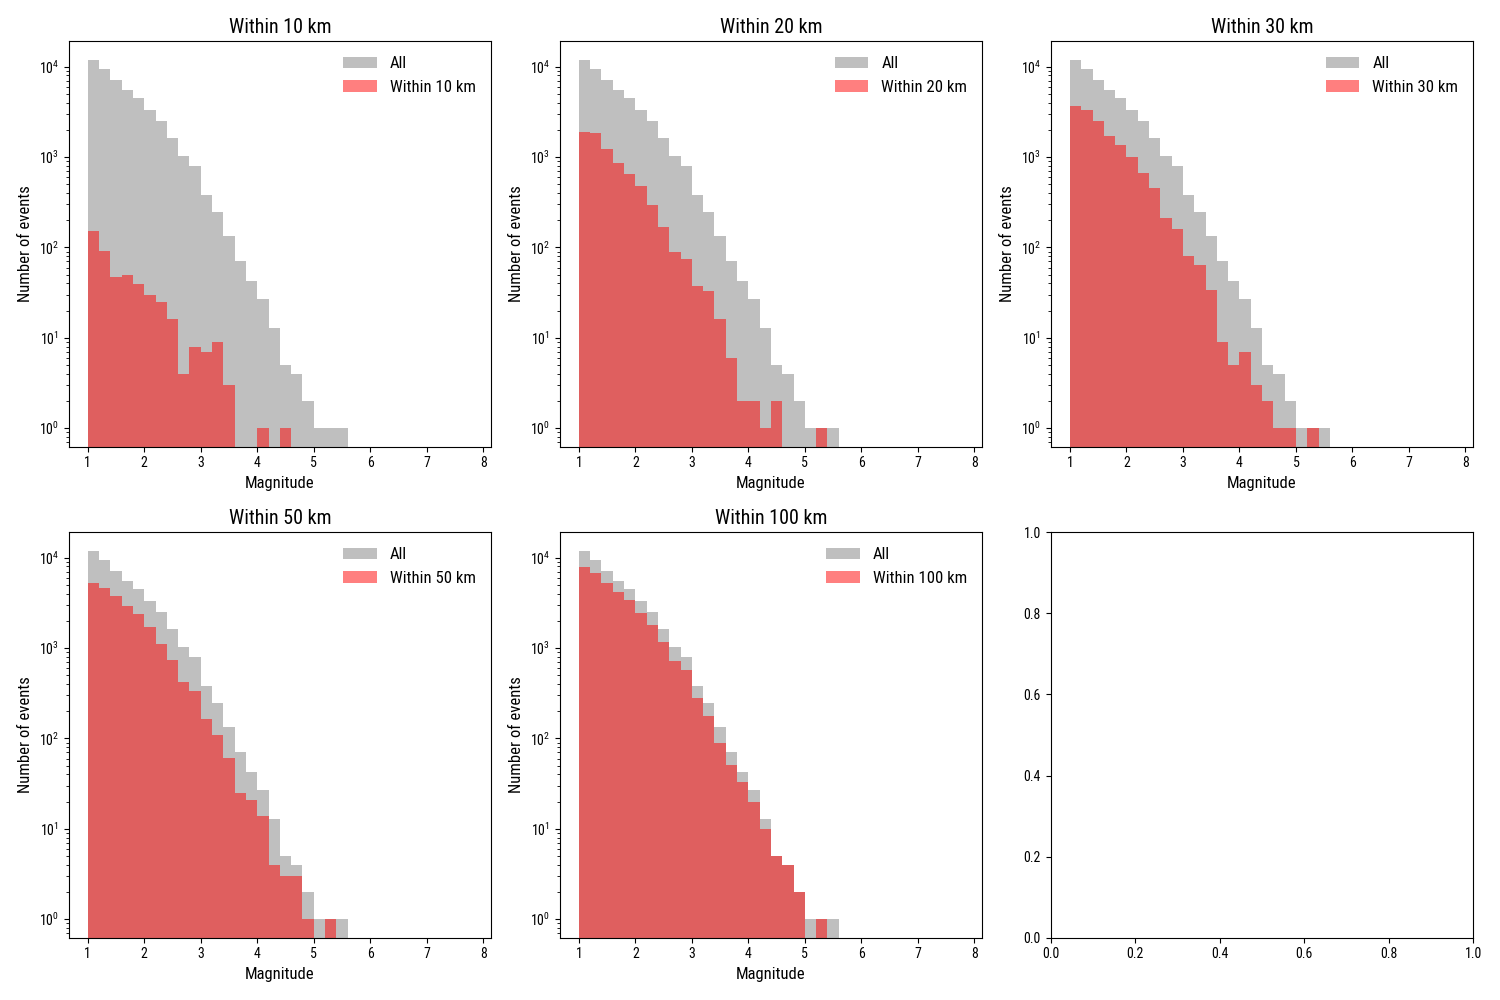

In [55]:
# Magnitude of completeness of each group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for jj, dist in enumerate(dists):
    ax = axes.flat[jj]
    ax.hist(selected_eq.mag, bins=np.arange(1, 8, .2), color='gray', alpha=.5, label='All', zorder=0)
    ax.hist(selected_eq.mag[eq_at_dist[jj]], bins=np.arange(1, 8, .2), color='red', alpha=.5, label='Within {:d} km'.format(dist), zorder=1)
    ax.set_title('Within {:d} km'.format(dist))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of events')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

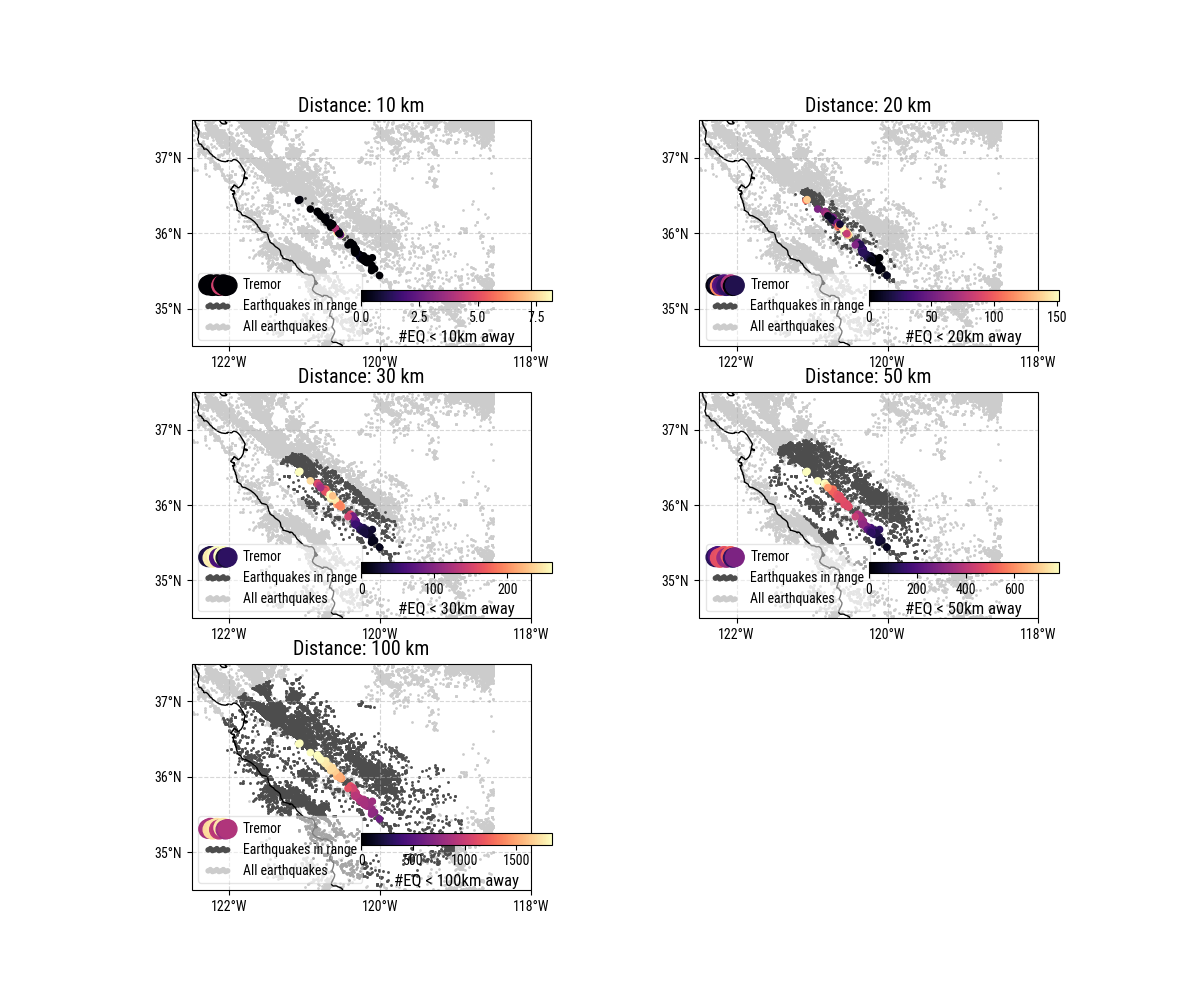

In [56]:
# Plot it
lon_min = -122.5
lon_max = -118.5
lat_min = 34.5
lat_max = 37.5
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 10))
axes = [plt.subplot(3, 2, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(dists)), axes):
    ax.set_title('Distance: {:d} km'.format(dists[ii]))
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # # Plot tremor
    sc = ax.scatter(lfe_fam.lon, lfe_fam.lat, c=n_eq[ii, :], s=20, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(n_eq[ii, :], 95), zorder=2, label='Tremor')
    ax.scatter(selected_eq.lon[eq_at_dist[ii]], selected_eq.lat[eq_at_dist[ii]], c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(dists[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    ax.legend(loc='lower left', fontsize='small', framealpha=.5, scatterpoints=10, markerscale=3)

    # Colorbar
    x_min_ax = 0.5; y_min_ax = 0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb = fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]))

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

# plt.tight_layout()
plt.show()

In [57]:
# Save it
print('Saving for {:}'.format(min_mag))
lfe_fam.loc[:, 'n_eq_10km'] = n_eq[0, :]
lfe_fam.loc[:, 'n_eq_20km'] = n_eq[1, :]
lfe_fam.loc[:, 'n_eq_30km'] = n_eq[2, :]
lfe_fam.loc[:, 'n_eq_50km'] = n_eq[3, :]
lfe_fam.loc[:, 'n_eq_100km'] = n_eq[4, :]

lfe_fam.to_csv('data/parkfield/processed/park_lfe_fam_0606_0122_eqdist_mc{:.1f}.csv'.format(min_mag), index=False)

lfe.to_csv('data/parkfield/processed/park_lfe_0606_0122.csv', index=False)

# Save the earthquakes
selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
selected_eq.loc[:, 'in30km'] = eq_at_dist[2, :]
selected_eq.loc[:, 'in50km'] = eq_at_dist[3, :]
selected_eq.loc[:, 'in100km'] = eq_at_dist[4, :]

selected_eq.to_csv('data/parkfield/processed/park_eqmc{:.1f}_0606_0122_eqdist.csv'.format(min_mag), index=False)

Saving for 1.0


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_5459/1323732696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_5459/1323732696.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_5459/1323732696.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from